# Everyone's favorite topic: Quality Control!

ARM uses three official types of Quality Control (QC).
* Embedded
* DQR
* Instrument Handbook / VAP Technical Report

The embedded QC will come with the netCDF file and can be used immediately, well sort of. Since ARM is 30+ years old the standards have changed. Initially it was assumed a researcher would read the netCDF file header and manually integrate the embedded QC or read the DQR reports and manually apply the results. That is not even possible anymore. Every researcher is using multiple files from multiple datastreams over multiple years. We need an automated process.

So after you have downloaded the data, you can read it and view the embedded quality control variables. ARM standard states an accompanying quality control variable will be the same variable name prepended with "qc_". Let's take a look at one.

In [1]:
import act
from pathlib import Path
import warnings
from matplotlib import pyplot as plt

warnings.filterwarnings('ignore')  # Turn off warnings for remainder of this tutorial

In [2]:
filename = str(Path('..', 'data', 'sgpmetE13.b1', 'sgpmetE13.b1.20191101.000000.cdf'))
filename

'../data/sgpmetE13.b1/sgpmetE13.b1.20191101.000000.cdf'

In [3]:
ds = act.io.armfiles.read_netcdf(filename)
ds

<xarray.Dataset>
Dimensions:                       (time: 1440)
Coordinates:
  * time                          (time) datetime64[ns] 2019-11-01 ... 2019-1...
Data variables: (12/50)
    base_time                     datetime64[ns] 2019-11-01
    time_offset                   (time) datetime64[ns] 2019-11-01 ... 2019-1...
    atmos_pressure                (time) float32 dask.array<chunksize=(1440,), meta=np.ndarray>
    qc_atmos_pressure             (time) int32 dask.array<chunksize=(1440,), meta=np.ndarray>
    temp_mean                     (time) float32 dask.array<chunksize=(1440,), meta=np.ndarray>
    qc_temp_mean                  (time) int32 dask.array<chunksize=(1440,), meta=np.ndarray>
    ...                            ...
    qc_logger_volt                (time) int32 dask.array<chunksize=(1440,), meta=np.ndarray>
    logger_temp                   (time) float32 dask.array<chunksize=(1440,), meta=np.ndarray>
    qc_logger_temp                (time) int32 dask.array<chunksize=(1440,), meta=np.ndarray>
    lat                           float32 ...
    lon                           float32 ...
    alt                           float32 ...
Attributes: (12/33)
    command_line:                met_ingest -s sgp -f E13
    process_version:             ingest-met-4.40-0.el7
    dod_version:                 met-b1-7.3
    input_source:                /data/collection/sgp/sgpmetE13.00/MET_Table1...
    site_id:                     sgp
    platform_id:                 met
    ...                          ...
    qc_bit_4_assessment:         Indeterminate
    history:                     created by user dsmgr on machine garnet at 2...
    _file_dates:                 ['20191101']
    _file_times:                 ['000000']
    _datastream:                 sgpmetE13.b1
    _arm_standards_flag:         1

Let's set a variable to the variable name in the Dataset and a second variable to the quality control variable name. Then we will print the DataArray to see the strucure of the data and attributes.

In [4]:
var_name = 'temp_mean'
qc_var_name = 'qc_' + var_name
ds[qc_var_name]

<xarray.DataArray 'qc_temp_mean' (time: 1440)>
dask.array<open_dataset-qc_temp_mean, shape=(1440,), dtype=int32, chunksize=(1440,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2019-11-01 ... 2019-11-01T23:59:00
Attributes:
    long_name:    Quality check results on field: Temperature mean
    units:        unitless
    description:  See global attributes for individual bit descriptions.

Notice that there are three variable attributes: _long_name, units, description_

_descripton_ just says go look at global attributes to decode? How does the ACT code know how to apply those? Well it does not right away. If we look at the global attributes, you can see they are a bit of a mess.

In [5]:
ds.attrs

{'command_line': 'met_ingest -s sgp -f E13',
 'process_version': 'ingest-met-4.40-0.el7',
 'dod_version': 'met-b1-7.3',
 'input_source': '/data/collection/sgp/sgpmetE13.00/MET_Table1.20191101000000.dat',
 'site_id': 'sgp',
 'platform_id': 'met',
 'facility_id': 'E13',
 'data_level': 'b1',
 'location_description': 'Southern Great Plains (SGP), Lamont, Oklahoma',
 'datastream': 'sgpmetE13.b1',
 'serial_number': '118',
 'sampling_interval': 'variable, see instrument handbook',
 'averaging_interval': '60 seconds',
 'averaging_interval_comment': 'The time assigned to each data point indicates the end of the averaging interval.',
 'tbrg': 'Tipping Bucket Rain Gauge',
 'pwd': 'Present Weather Detector',
 'wind_speed_offset': '0.000000',
 'wind_speed_slope': '0.098000',
 'tbrg_precip_corr_info': '0.000000 * tbrg_precip_total^2 + 1.024000 * tbrg_precip_total',
 'qc_bit_comment': 'The QC field values are a bit packed representation of true/false values for the tests that may have been performed.

While there is a standard for the ARM QC it's not the one used by CF or ACT. So we need to update it. Luckily ACT can do this for you. We just need to call the cleanup() method to convert all the declaration of QC values from the global attributes to declarations uder the QC variable.

In [6]:
ds.clean.cleanup()

In [7]:
ds[qc_var_name]

<xarray.DataArray 'qc_temp_mean' (time: 1440)>
dask.array<open_dataset-qc_temp_mean, shape=(1440,), dtype=int32, chunksize=(1440,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2019-11-01 ... 2019-11-01T23:59:00
Attributes:
    long_name:         Quality check results on field: Temperature mean
    units:             1
    flag_masks:        [1, 2, 4, 8]
    flag_meanings:     ['Value is equal to missing_value.', 'Value is less th...
    flag_assessments:  ['Bad', 'Bad', 'Bad', 'Indeterminate']
    fail_min:          -40.0
    fail_max:          50.0
    fail_delta:        20.0
    standard_name:     quality_flag

Notice how we have additional variable attributes listed under the quality control variable. Specifically there are new attributes: _flag_meanings, flag_masks, flag_assessments standard_name_ and the limit variables _fail_min, fail_max, fail_delta_. These are the required variable attributes defined under the CF standard. ACT uses that standard (mostly, a little better in fact) to make applying QC trivial. Almost too trivial in fact.

But there is an even easier way to do all this. Instead of calling the cleanup() method after reading the data it can be applied during the reading call.

In [8]:
ds = act.io.armfiles.read_netcdf(filename, cleanup_qc=True)
ds[qc_var_name]

<xarray.DataArray 'qc_temp_mean' (time: 1440)>
dask.array<open_dataset-qc_temp_mean, shape=(1440,), dtype=int32, chunksize=(1440,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2019-11-01 ... 2019-11-01T23:59:00
Attributes:
    long_name:         Quality check results on field: Temperature mean
    units:             1
    flag_masks:        [1, 2, 4, 8]
    flag_meanings:     ['Value is equal to missing_value.', 'Value is less th...
    flag_assessments:  ['Bad', 'Bad', 'Bad', 'Indeterminate']
    fail_min:          -40.0
    fail_max:          50.0
    fail_delta:        20.0
    standard_name:     quality_flag

And once we have the QC variable cleaned up we don't even need to know the name of the QC variable. The use of the standard_name attribute along with _ancillary_variables_ under the data variable means the code just knows what to do.

So in fact we can ask ACT what is the name of the QC variable?

In [9]:
ds.qcfilter.check_for_ancillary_qc(var_name)

'qc_temp_mean'

Now that we have the data read and QC variable updated, we can use the QC. The question is how do you want to use the QC? The next logical step is to check the other location for QC - DQRs. We can use a function in ACT to query the ARM program for the DQR information and apply it to the Dataset we have. It will use a web-service to query the DQR database and if it finds a DQR that applies to the datastream we have read over the data dates it will add additional tests to the QC variable.

In [10]:
ds = act.qc.arm.add_dqr_to_qc(ds)

In [11]:
ds['qc_temp_mean']

<xarray.DataArray 'qc_temp_mean' (time: 1440)>
dask.array<open_dataset-qc_temp_mean, shape=(1440,), dtype=int32, chunksize=(1440,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2019-11-01 ... 2019-11-01T23:59:00
Attributes:
    long_name:         Quality check results on field: Temperature mean
    units:             1
    flag_masks:        [1, 2, 4, 8]
    flag_meanings:     ['Value is equal to missing_value.', 'Value is less th...
    flag_assessments:  ['Bad', 'Bad', 'Bad', 'Indeterminate']
    fail_min:          -40.0
    fail_max:          50.0
    fail_delta:        20.0
    standard_name:     quality_flag

In this case there are no DQRs to apply so nothing is changed with the QC variable.

But lets read in some data from the ACT examples that does have a DQR to apply so we can see what is going on.

In [12]:
# Read in sample AOSMET data
files = act.tests.sample_files.EXAMPLE_AOSMET
ds_aosmet = act.io.armfiles.read_netcdf(files)

And this time we are going to ask that only one variable is updated.

In [13]:
variable = 'temperature_ambient'
ds_aosmet = act.qc.arm.add_dqr_to_qc(ds_aosmet, variable=variable)

In [14]:
qc_variable = ds_aosmet.qcfilter.check_for_ancillary_qc(variable)
ds_aosmet[qc_variable]

<xarray.DataArray 'qc_temperature_ambient' (time: 1440)>
array([0, 0, 0, ..., 1, 1, 1], dtype=int32)
Coordinates:
  * time     (time) datetime64[ns] 2018-02-01 ... 2018-02-01T23:59:00
Attributes:
    long_name:         Quality check results on field: Ambient air temperature
    units:             1
    flag_masks:        [1]
    flag_meanings:     ['D180212.1: MAR/AOS/M1 - Ship exhaust contamination']
    flag_assessments:  ['Bad']
    standard_name:     quality_flag

In this example, a QC variable does not exist in the netCDF file. When we tell ACT to apply the DQR it notices this missing QC variable and makes it before adding the results from the DQR web-service call. Notice we now have one test and the description indicates the DQR ID number so we can review it for further detail.

Now that we have the QC updated we can look at the data and the QC information in one plot. The first axes is a plot of the data. The second axes is a plot of the quality control information. Since the QC information is a simple true false time series it is plotted like a shading plot. It also indicates the test number and the description of the test on the axes.

Notice how we used the _assessment_overplot=True_ keyword in the .plot() call to ask that the QC is set to overlay red points. There are a lot of options/features in ACT to handle QC. Chances are if you need to do something, it's already in there.

0.2.0


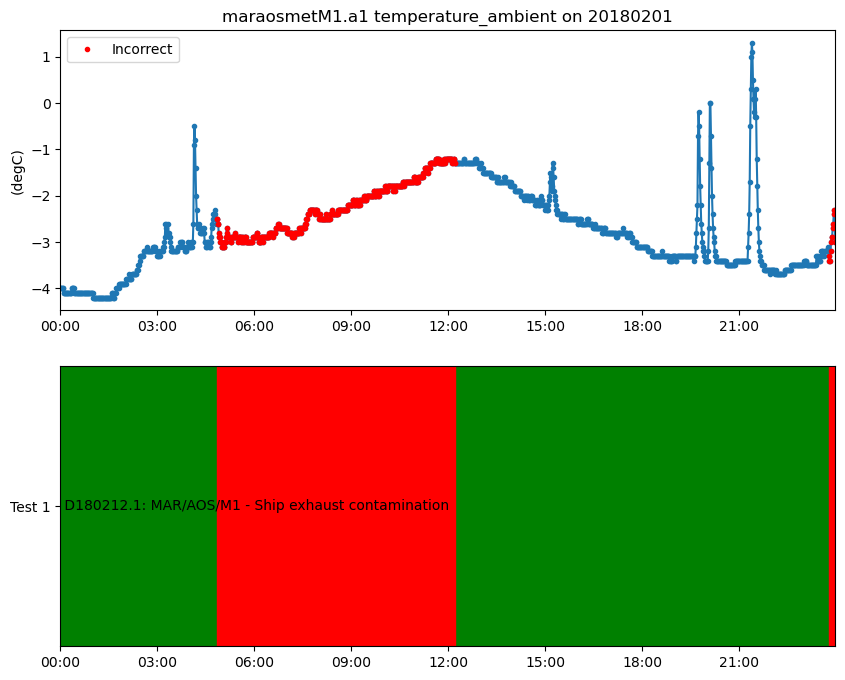

In [15]:
# Plot data
# Creat Plot Display
display = act.plotting.TimeSeriesDisplay(ds_aosmet, figsize=(10, 8), subplot_shape=(2,))

# Plot temperature data in top plot
display.plot(variable, subplot_index=(0,), assessment_overplot=True)

# Plot QC data
display.qc_flag_block_plot(variable, subplot_index=(1,))
plt.show()